# Making predictions over amazon recommendation dataset

## Predictions
The purpose of this analysis is to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation. 

To do so, we will work on Amazon's recommendation dataset, we will build a Term-doc incidence matrix using term frequency and inverse document frequency ponderation. When the data is ready, we will load it into predicitve algorithms, mainly naïve Bayesian and regression.

In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

## Loading the data
In order to load the data, we will use the SQLITE dataset where we will only fetch the Score and the recommendation summary. 

As we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "postive". Otherwise, it will be set to "negative". 

The data will be split into an training set and a test set with a test set ratio of 0.2

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

Let's first check whether we have the dataset available:

In [2]:
import os
from IPython.core.display import display, HTML
    
if not os.path.isfile('../input/database.sqlite'):
    display(HTML("""
        <h3 style='color: red'>Dataset database missing!</h3><h3> Please download it
        <a href='https://www.kaggle.com/snap/amazon-fine-food-reviews'>from here on Kaggle</a>
        and extract it to the current directory.
          """))
    raise(Exception("missing dataset"))
        

In [3]:
con = sqlite3.connect('../input/database.sqlite')

pd.read_sql_query("SELECT * FROM Reviews LIMIT 3", con)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Let's select only what's of interest to us:

In [4]:
messages = pd.read_sql_query("""
SELECT 
  Score, 
  Summary, 
  HelpfulnessNumerator as VotesHelpful, 
  HelpfulnessDenominator as VotesTotal
FROM Reviews 
WHERE Score != 3""", con)

Let's see what we've got:

In [5]:
messages.head(5)

,Score,Summary,VotesHelpful,VotesTotal
0,5,Good Quality Dog Food,1,1
1,1,Not as Advertised,0,0
2,4,"""Delight"" says it all",1,1
3,2,Cough Medicine,3,3
4,5,Great taffy,0,0


Let's add the **Sentiment** column that turns the numeric score into either *positive* or *negative*.

Similarly, the **Usefulness** column turns the number of votes into a boolean.

In [6]:
messages["Sentiment"] = messages["Score"].apply(lambda score: "positive" if score > 3 else "negative")
messages["Usefulness"] = (messages["VotesHelpful"]/messages["VotesTotal"]).apply(lambda n: "useful" if n > 0.8 else "useless")

messages.head(5)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,positive,useful
1,1,Not as Advertised,0,0,negative,useless
2,4,"""Delight"" says it all",1,1,positive,useful
3,2,Cough Medicine,3,3,negative,useful
4,5,Great taffy,0,0,positive,useless


Let's have a look at some 5s:

In [7]:
messages[messages.Score == 5].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,positive,useful
4,5,Great taffy,0,0,positive,useless
6,5,Great! Just as good as the expensive brands!,0,0,positive,useless
7,5,"Wonderful, tasty taffy",0,0,positive,useless
8,5,Yay Barley,1,1,positive,useful
9,5,Healthy Dog Food,0,0,positive,useless
10,5,The Best Hot Sauce in the World,1,1,positive,useful
11,5,"My cats LOVE this ""diet"" food better than thei...",4,4,positive,useful
14,5,Strawberry Twizzlers - Yummy,4,5,positive,useless
15,5,"Lots of twizzlers, just what you expect.",4,5,positive,useless


And some 1s as well:

In [8]:
messages[messages.Score == 1].head(10)

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness
1,1,Not as Advertised,0,0,negative,useless
12,1,My Cats Are Not Fans of the New Food,1,1,negative,useful
26,1,Nasty No flavor,0,1,negative,useless
47,1,Don't like it,0,7,negative,useless
57,1,stale product.,2,2,negative,useful
67,1,Warning! WARNING! -ALCOHOL SUGARS!,0,1,negative,useless
69,1,No Tea Flavor,0,0,negative,useless
90,1,Bad,0,1,negative,useless
140,1,Rip off Price,1,1,negative,useful
150,1,Tasteless but low calorie,0,4,negative,useless


## Extracting features from text data

SciKit cannot work with words, so we'll just assign a new dimention to each word and work with word counts.

See more here: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

messages["Summary_Clean"] = messages["Summary"].apply(cleanup)

train, test = train_test_split(messages, test_size=0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

420651 items in training data, 105163 in test data


In [10]:
from wordcloud import WordCloud, STOPWORDS

# To cleanup stop words, add stop_words = STOPWORDS
# But it seems to function better without it
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary_Clean"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Sentiment"]
y_test = test["Sentiment"]

prediction = dict()

## Let's get fancy with WordClouds!

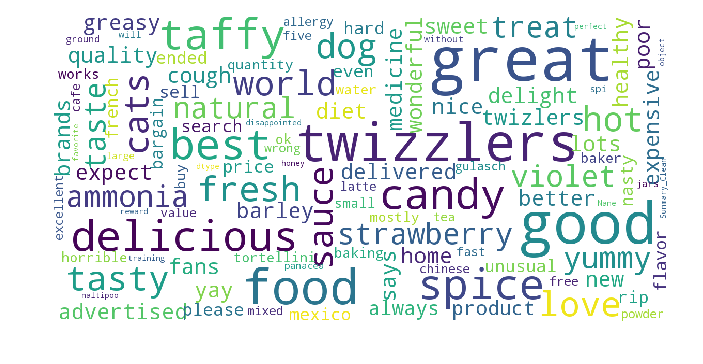

In [11]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
mpl.rcParams['font.size']=12                #10 
mpl.rcParams['savefig.dpi']=100             #72 
mpl.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(messages["Summary_Clean"])

We can also view wordclouds for only positive or only negative entries:

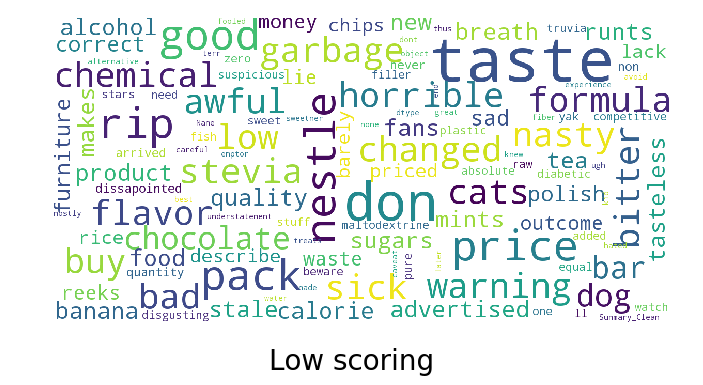

In [12]:
show_wordcloud(messages[messages.Score == 1]["Summary_Clean"], title = "Low scoring")

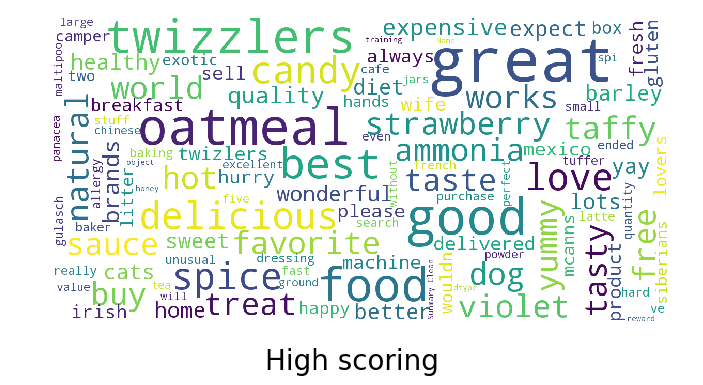

In [13]:
show_wordcloud(messages[messages.Score == 5]["Summary_Clean"], title = "High scoring")

## Applying Multinomial Naïve Bayes learning method

In [14]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

## Applying Bernoulli Naïve Bayes learning method

In [15]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

## Applying Logistic regression learning method

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

## Results

In order to compare our learning algorithms, let's build the ROC curve. The curve with the highest AUC value will show our "best" algorithm.

In first data cleaning, stop-words removal has been used, but the results were much worse. Reason for this result could be that when people want to speak about what is or is not good, they use many small words like "not" for instance, and these words will typically be tagged as stop-words, and will be removed. This is why in the end, it was decided to keep the stop-words. For those who would like to try it by themselves, I have let the stop-words removal as a comment in the cleaning part of the analysis.

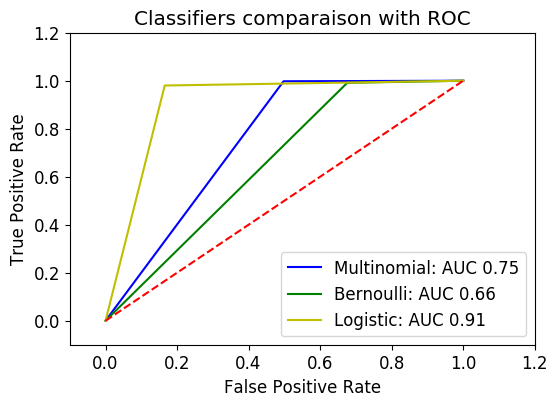

In [17]:
def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

After plotting the ROC curve, it would appear that the Logistic regression method provides us with the best results, although the AUC value for this method is not outstanding... 

Let's remember what Precision and Recall are (more here https://en.wikipedia.org/wiki/Precision_and_recall)

![Precision_Recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png)

Let's focus on logistic regression, and vizualise the accuracy, recall and confusion matrix of this model:

In [18]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.89      0.83      0.86     16461
   negative       0.97      0.98      0.97     88702

avg / total       0.96      0.96      0.96    105163



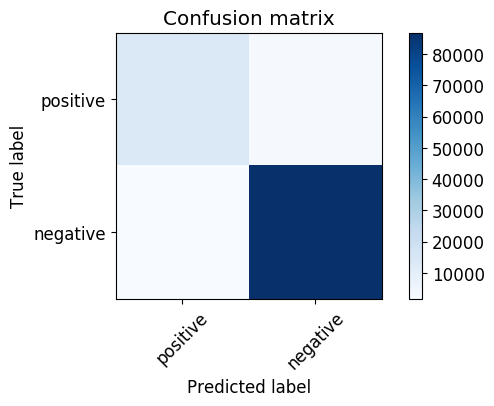

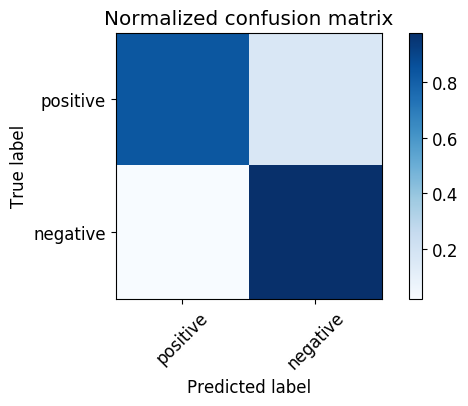

In [19]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

Let's also have a look at what the best & words are by looking at the coefficients:

In [20]:
words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame(
    data = list(zip(words, logreg_result.coef_[0])),
    columns = ['feature', 'coef'])

feature_coefs.sort_values(by='coef')

,feature,coef
966883,worst,-42.314767
983063,yuck,-32.065303
820371,terrible,-31.725466
61595,awful,-30.453291
587912,not,-29.013337
422215,horrible,-28.913973
569919,nasty,-24.627566
227286,disgusting,-24.140110
966756,worse,-23.836602
55556,at best,-23.478293


In [21]:
def test_sample(model, sample):
    sample_counts = count_vect.transform([sample])
    sample_tfidf = tfidf_transformer.transform(sample_counts)
    result = model.predict(sample_tfidf)[0]
    prob = model.predict_proba(sample_tfidf)[0]
    print("Sample estimated as %s: negative prob %f, positive prob %f" % (result.upper(), prob[0], prob[1]))

test_sample(logreg, "The food was delicious, it smelled great and the taste was awesome")
test_sample(logreg, "The whole experience was horrible. The smell was so bad that it literally made me sick.")
test_sample(logreg, "The food was ok, I guess. The smell wasn't very good, but the taste was ok.")

Sample estimated as POSITIVE: negative prob 0.001154, positive prob 0.998846
Sample estimated as NEGATIVE: negative prob 0.999992, positive prob 0.000008
Sample estimated as NEGATIVE: negative prob 0.647653, positive prob 0.352347


There are also some weird predictions:

In [22]:
test_sample(logreg, "The smell reminded me of ammonia")

Sample estimated as NEGATIVE: negative prob 0.945204, positive prob 0.054796


# Now let's try to predict how helpful a product is

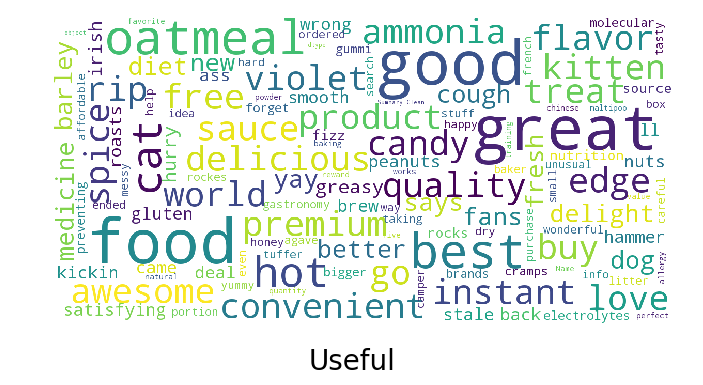

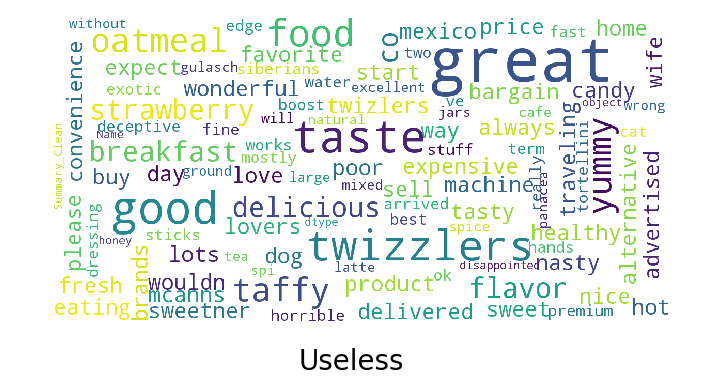

In [23]:
show_wordcloud(messages[messages.Usefulness == "useful"]["Summary_Clean"], title = "Useful")
show_wordcloud(messages[messages.Usefulness == "useless"]["Summary_Clean"], title = "Useless")

Nothing seems to pop out.. let's try to limit the dataset to only entries with at least 10 votes.

In [24]:
messages_ufn = messages[messages.VotesTotal >= 10]
messages_ufn.head()

,Score,Summary,VotesHelpful,VotesTotal,Sentiment,Usefulness,Summary_Clean
32,4,Best of the Instant Oatmeals,19,19,positive,useful,best of the instant oatmeals
33,4,Good Instant,13,13,positive,useful,good instant
75,5,Forget Molecular Gastronomy - this stuff rocke...,15,15,positive,useful,forget molecular gastronomy this stuff rockes ...
145,5,tastes very fresh,17,19,positive,useful,tastes very fresh
195,1,CHANGED FORMULA MAKES CATS SICK!!!!,3,10,negative,useless,changed formula makes cats sick


Now let's try again with the word clouds:

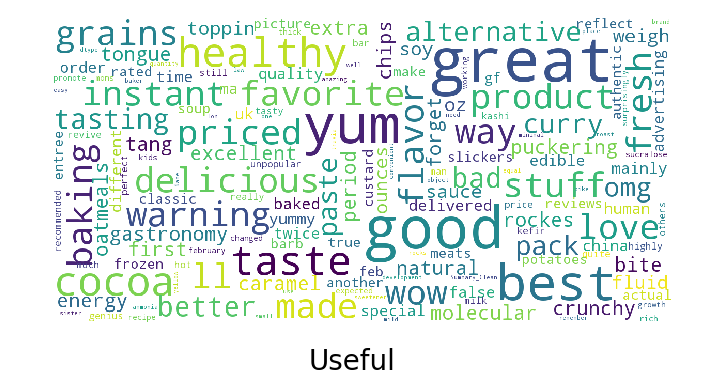

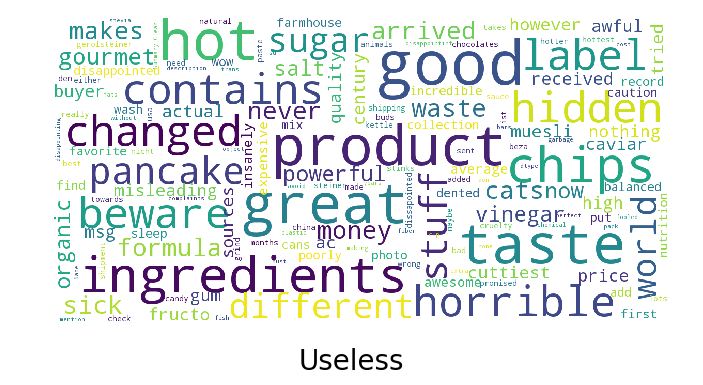

In [25]:
show_wordcloud(messages_ufn[messages_ufn.Usefulness == "useful"]["Summary_Clean"], title = "Useful")
show_wordcloud(messages_ufn[messages_ufn.Usefulness == "useless"]["Summary_Clean"], title = "Useless")

This seems a bit better, let's see if we can build a model though

In [26]:
from sklearn.pipeline import Pipeline

train_ufn, test_ufn = train_test_split(messages_ufn, test_size=0.2)

ufn_pipe = Pipeline([
    ('vect', CountVectorizer(min_df = 1, ngram_range = (1, 4))),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(C=1e5)),
])

ufn_result = ufn_pipe.fit(train_ufn["Summary_Clean"], train_ufn["Usefulness"])

prediction['Logistic_Usefulness'] = ufn_pipe.predict(test_ufn["Summary_Clean"])
print(metrics.classification_report(test_ufn["Usefulness"], prediction['Logistic_Usefulness']))

             precision    recall  f1-score   support

     useful       0.83      0.89      0.86      2954
    useless       0.77      0.67      0.72      1659

avg / total       0.81      0.81      0.81      4613



Let's also see which of the reviews are rated by our model as most helpful and least helpful:

In [27]:
ufn_scores = [a[0] for a in ufn_pipe.predict_proba(train_ufn["Summary"])]
ufn_scores = zip(ufn_scores, train_ufn["Summary"], train_ufn["VotesHelpful"], train_ufn["VotesTotal"])
ufn_scores = sorted(ufn_scores, key=lambda t: t[0], reverse=True)

# just make this into a DataFrame since jupyter renders it nicely:
pd.DataFrame(ufn_scores)

,0,1,2,3
0,9.999999e-01,Great for Baking,23,23
1,9.999999e-01,Great for baking,11,11
2,9.999999e-01,Great for baking,12,13
3,9.999999e-01,Great for baking,9,10
4,9.999999e-01,Great for Baking-,14,15
5,9.999999e-01,Great for baking!,10,10
6,9.999999e-01,Great for Baking,10,11
7,9.999999e-01,Great for baking,12,13
8,9.999999e-01,best bread,24,24
9,9.999999e-01,Best quality,18,18


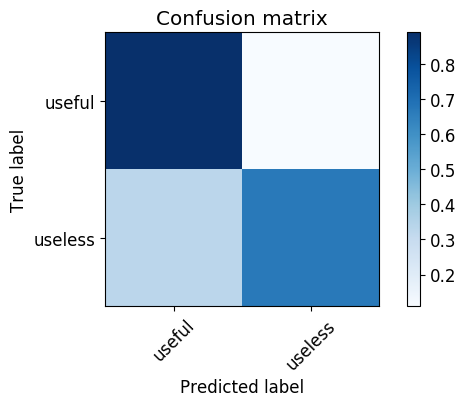

In [28]:
cm = confusion_matrix(test_ufn["Usefulness"], prediction['Logistic_Usefulness'])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm_normalized, labels=["useful", "useless"])

# Even more complicated pipeline

In [29]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Useful to select only certain features in a dataset for forwarding through a pipeline
# See: http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, x, y=None):
        return self
    def transform(self, data_dict):
        return data_dict[self.key]

train_ufn2, test_ufn2 = train_test_split(messages_ufn, test_size=0.2)

ufn_pipe2 = Pipeline([
   ('union', FeatureUnion(
       transformer_list = [
           ('summary', Pipeline([
               ('textsel', ItemSelector(key='Summary_Clean')),
               ('vect', CountVectorizer(min_df = 1, ngram_range = (1, 4))),
               ('tfidf', TfidfTransformer())])),
          ('score', ItemSelector(key=['Score']))
       ],
       transformer_weights = {
           'summary': 0.2,
           'score': 0.8
       }
   )),
   ('model', LogisticRegression(C=1e5))
])

ufn_result2 = ufn_pipe2.fit(train_ufn2, train_ufn2["Usefulness"])
prediction['Logistic_Usefulness2'] = ufn_pipe2.predict(test_ufn2)
print(metrics.classification_report(test_ufn2["Usefulness"], prediction['Logistic_Usefulness2']))

             precision    recall  f1-score   support

     useful       0.86      0.90      0.88      2986
    useless       0.80      0.73      0.76      1627

avg / total       0.84      0.84      0.84      4613



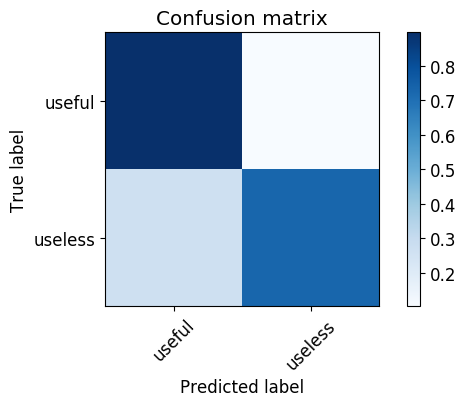

In [30]:
cm = confusion_matrix(test_ufn2["Usefulness"], prediction['Logistic_Usefulness2'])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm_normalized, labels=["useful", "useless"])

In [31]:
len(ufn_result2.named_steps['model'].coef_[0])

86878

Again, let's have a look at the best/worst words:

In [32]:
ufn_summary_pipe = next(tr[1] for tr in ufn_result2.named_steps["union"].transformer_list if tr[0]=='summary')
ufn_words = ufn_summary_pipe.named_steps['vect'].get_feature_names()
ufn_features = ufn_words + ["Score"]
ufn_feature_coefs = pd.DataFrame(
    data = list(zip(ufn_features, ufn_result2.named_steps['model'].coef_[0])),
    columns = ['feature', 'coef'])
ufn_feature_coefs.sort_values(by='coef')

,feature,coef
9551,blk water,-78.068077
50572,not buy this product,-67.747732
30251,god awful,-64.608586
32285,great for,-59.935117
85029,wouldn recommend,-59.325990
36395,hot chocolate,-58.851137
36820,hype water,-58.538783
61579,really really bad,-57.449979
6082,bad product,-57.320437
2282,and,-55.217904


In [33]:
print("And the coefficient of the Score variable: ")
ufn_feature_coefs[ufn_feature_coefs.feature == 'Score']

And the coefficient of the Score variable: 


,feature,coef
86877,Score,-1.854622
